In [1]:
import ast
import json
import random
import pandas as pd
from scipy import stats
import numpy as np
from board import get_piece_name_at_location, convert_board
from matplotlib import pyplot as plt

In [3]:
# Hyperparams
output_dir = "processed_data"
default_samples = 2500
task = "gym_train"                # {'rejsampling', 'eval'}
board_notation = "visual"    # {fen, spaced_fen, visual_simple, visual}

# Download our input files
input_files = {
    #"gym_eval": './deepmind_data/evals_1k.csv',
    "gym_eval": 'evals_1k_copy.csv',
    "gym_train": 'train_20k_copy.csv',
    "eval": './deepmind_data/evals_1k.csv',
    "rejsampling": './deepmind_data/train_20k.csv'
}
input_filename = input_files[task]
df = pd.read_csv(input_filename)
df['Move'] = df['Move'].apply(ast.literal_eval)
df['Win Probability'] = df['Win Probability'].apply(ast.literal_eval)

### List all Legal Moves for piece / board state
---
Given a piece and a board state, list all legal moves. Will measure:
- % of legal moves predicted ($\frac{\text{num legal moves predicted}}{\text{num total legal moves}}$)
- % of moves predicted that were legal ($\frac{\text{num legal moves predicted}}{\text{total num moves predicted}}$)
- % Error Rate (not following parse directions)

In [4]:
# Hyperparams
min_moves = 2
overwrite_samples = None

# Shuffle dataframe and make a deep copy of it
legalmoves_df = df.sample(frac=1, ignore_index=True).copy(deep=True)
samples = overwrite_samples if overwrite_samples else default_samples

# Iterate through and get samples
outputs = []
for index, row in legalmoves_df.iterrows():
    if len(outputs) >= samples:
        break
    
    # Otherwise get possible moves from the board
    board = row['FEN']
    moveset = row['Move']

    # Get the counts of the various pieces in the moveset
    piece_counts = {}
    for move in moveset:
        piece_pos = move[:2]
        piece_counts[piece_pos] = piece_counts.get(piece_pos, 0) + 1
    valid_pieces = [k for k, v in piece_counts.items() if v >= min_moves]
    if not valid_pieces:
        continue  # Skip if no valid pieces w/ enough moves

    # Sample a piece from the valid pieces
    piece = random.choice(valid_pieces)
    piece_name = get_piece_name_at_location(board, piece)
    if piece_name is None:
        print(f"Piece not found at {piece} in FEN: {board}")
        continue
    
    user = f"""Below is a board in a game you're currently playing.

{convert_board(board, board_notation)}

You must provide a list of all legal moves for the {piece_name} at {piece}.

You may want to think out loud to help finalize your answer. However, you must provide your answer within answer tags (e.g., <answer> list_of_moves </answer>).

The moves must be provided as a list, in UCI notation, and within answer tags in order to be accepted."""
    
    chat_history = [
        ['system', "chess_task_sysprompt.txt"], 
        ['user', user], 
        ['assistant', ""], 
    ]
    
    legal_moves = [move for move in moveset if move.startswith(piece)]
    info = {
        'board': board,
        'answer': legal_moves
    }
    
    outputs.append({
        'chat': chat_history,
        'info': info
    })

# Export as jsonl
jsonl_path = f'legalmoves_{task}_{len(outputs)}.jsonl'
with open(jsonl_path, 'w', encoding='utf-8') as f:
    for obj in outputs:
        f.write(json.dumps(obj) + '\n')
print(f"Saved JSONL to {jsonl_path}")

Saved JSONL to legalmoves_gym_train_2500.jsonl


### Given a list of submoves, predict the worst move
---


In [5]:
# Hyperparams
provided_move_nums = [2, 3, 4, 5, 6]
#provided_moves = 5
overwrite_samples = None
worst_move_thresh = 0.2

# Shuffle dataframe and make a deep copy of it
submoves_df = df.sample(frac=1, ignore_index=True).copy(deep=True)
samples = overwrite_samples if overwrite_samples else default_samples

# Iterate through and get samples
for provided_moves in provided_move_nums:
    outputs = []
    for index, row in submoves_df.iterrows():
        if len(outputs) >= samples:
            break

        board = row['FEN']
        moveset = row['Move']
        win_probs = row['Win Probability']

        move_prob_pairs = list(zip(moveset, win_probs))
        worst_move, worst_move_win_prob = min(move_prob_pairs, key=lambda x: x[1])

        filtered_moves = [
            move for move, prob in move_prob_pairs
            if prob > worst_move_thresh + worst_move_win_prob
        ]

        if len(filtered_moves) < provided_moves-1:
            continue

        sampled_moves = random.sample(filtered_moves, provided_moves-1)
        sampled_moves.append(worst_move)
        random.shuffle(sampled_moves)

        user_prompt = f"""Below is a board in a game you're currently playing.

    {convert_board(board, board_notation)}
        
    You must choose the worst move from the following moves: {sampled_moves}. 

    You may want to think out loud to help finalize your answer. However, you must provide your answer within answer tags (e.g., <answer> worst_move </answer>).

    The move must be provided in UCI notation and within answer tags in order to be accepted."""

        chat_history = [
            ['system', "chess_task_sysprompt.txt"],
            ['user', user_prompt],
            ['assistant', ""], 
        ]
        info = {
            'board': board,
            'answer': {'answer': worst_move, 'candidates': sampled_moves}
        }

        outputs.append({
            'chat': chat_history,
            'info': info
        })

    # Export as jsonl
    jsonl_path = f'worstmove_{task}_{provided_moves}provided_{len(outputs)}.jsonl'
    with open(jsonl_path, 'w', encoding='utf-8') as f:
        for obj in outputs:
            f.write(json.dumps(obj) + '\n')
    print(f"Saved JSONL to {jsonl_path}")

Saved JSONL to worstmove_gym_train_2provided_2500.jsonl
Saved JSONL to worstmove_gym_train_3provided_2500.jsonl
Saved JSONL to worstmove_gym_train_4provided_2500.jsonl
Saved JSONL to worstmove_gym_train_5provided_2500.jsonl
Saved JSONL to worstmove_gym_train_6provided_2500.jsonl


### Given a list of submoves, predict the best move

In [6]:
# Hyperparams
provided_move_nums = [2, 3, 4, 5, 6]
overwrite_samples = None
best_move_thresh = 0.2

# Shuffle dataframe and make a deep copy of it
submoves_df = df.sample(frac=1, ignore_index=True).copy(deep=True)
samples = overwrite_samples if overwrite_samples else default_samples

# Iterate through and get samples

for provided_moves in provided_move_nums:
    outputs = []
    for index, row in submoves_df.iterrows():
        if len(outputs) >= samples:
            break

        board = row['FEN']
        moveset = row['Move']
        win_probs = row['Win Probability']

        move_prob_pairs = list(zip(moveset, win_probs))

        # Find the best move (highest win probability)
        best_move, best_move_win_prob = max(move_prob_pairs, key=lambda x: x[1])

        # Filter out moves with win probability < best_move_win_prob - best_move_thresh
        filtered_moves = [
            move for move, prob in move_prob_pairs
            if prob < best_move_win_prob - best_move_thresh
        ]

        if len(filtered_moves) < provided_moves - 1:
            continue

        sampled_moves = random.sample(filtered_moves, provided_moves - 1)
        sampled_moves.append(best_move)
        random.shuffle(sampled_moves)

        user_prompt = f"""Below is a board in a game you're currently playing.

    {convert_board(board, board_notation)}
        
    You must choose the best move from the following moves: {sampled_moves}. 

    You may want to think out loud to help finalize your answer. However, you must provide your answer within answer tags (e.g., <answer> best_move </answer>).

    The move must be provided in UCI notation and within answer tags in order to be accepted."""

        chat_history = [
            ['system', "chess_task_sysprompt.txt"],
            ['user', user_prompt],
            ['assistant', ""], 
        ]
        info = {
            'board': board,
            'answer': {'answer': best_move, 'candidates': sampled_moves}
        }

        outputs.append({
            'chat': chat_history,
            'info': info
        })

    # Export as jsonl
    jsonl_path = f'bestmove_{task}_{provided_moves}provided_{len(outputs)}.jsonl'
    with open(jsonl_path, 'w', encoding='utf-8') as f:
        for obj in outputs:
            f.write(json.dumps(obj) + '\n')
    print(f"Saved JSONL to {jsonl_path}")

Saved JSONL to bestmove_gym_train_2provided_2500.jsonl
Saved JSONL to bestmove_gym_train_3provided_2500.jsonl
Saved JSONL to bestmove_gym_train_4provided_2500.jsonl
Saved JSONL to bestmove_gym_train_5provided_2500.jsonl
Saved JSONL to bestmove_gym_train_6provided_2500.jsonl


### Given a board (no legal moves provided), give a move

In [13]:
def clipped_normalize_rewards(z_scores, threshold=0.5):
    z_scores = np.array(z_scores, dtype=float)

    # Step 1: Normalize to range [0, 1]
    z_min = np.min(z_scores)
    z_max = np.max(z_scores)
    
    if np.isclose(z_min, z_max):  # Avoid division by zero
        return np.zeros_like(z_scores)

    normalized = (z_scores - z_min) / (z_max - z_min)

    # Step 2: Apply threshold (set values < threshold to 0)
    normalized[normalized < threshold] = 0

    # Step 3: Renormalize to [0, 1] if necessary
    new_min = np.min(normalized)
    new_max = np.max(normalized)

    if np.isclose(new_min, new_max):  # If all remaining values are the same, return as is
        return np.zeros_like(normalized) if new_max == 0 else np.ones_like(normalized)

    return (normalized - new_min) / (new_max - new_min)


def reward_clipped(legal_moves, win_probabilities, clipping_threshold=0.5):
    z_scores = stats.zscore(win_probabilities)
    rewards = clipped_normalize_rewards(z_scores, clipping_threshold)
    return dict(zip(legal_moves, rewards))

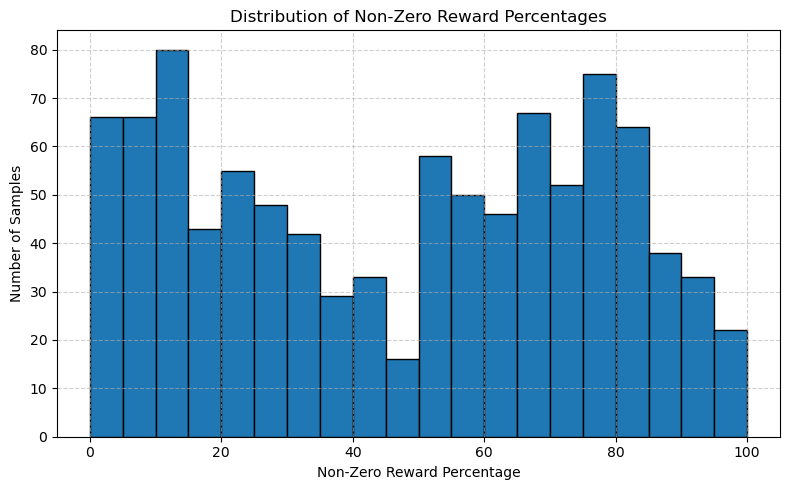

In [20]:
# Hyperparams
overwrite_samples = None
min_possible_moves = 3

# Shuffle / compute samples
predmove_df = df.sample(frac=1, ignore_index=True).copy(deep=True)
samples = overwrite_samples if overwrite_samples else default_samples

all_move_zscores = []
non_zero_percentages = []

# Main code
outputs = []
for index, row in predmove_df.iterrows():
    if len(outputs) >= samples:
        break

    board = row['FEN']
    moveset = row['Move']
    win_probs = row['Win Probability']

    if len(moveset) < min_possible_moves:
        continue

    move_zscores = reward_clipped(moveset, win_probs, 0.65)
    all_move_zscores.append(move_zscores)

    move_prob_dict = dict(zip(moveset, win_probs))

    user_prompt = f"""Below is a chess board from your current game.

{convert_board(board, board_notation)}

You must select the best move from this position and return it within answer tags. Your answer must be formatted as <answer> my_move </answer>, where my_move is a legal move in UCI notation.

Think step by step if necessary, but do not omit the answer tags or UCI format. Only answers in the correct format will be accepted."""

    chat_history = [
        ['system', "chess_task_sysprompt.txt"],
        ['user', user_prompt],
        ['assistant', ""], 
    ]

    info = {
        'board': board,
        'answer': move_prob_dict
    }

    outputs.append({
        'chat': chat_history,
        'info': info
    })

# Export as jsonl
# jsonl_path = f'./{output_dir}/predictmove_{task}_{len(outputs)}.jsonl'
# with open(jsonl_path, 'w', encoding='utf-8') as f:
#     for obj in outputs:
#         f.write(json.dumps(obj) + '\n')
# print(f"Saved JSONL to {jsonl_path}")




for move_zscores in all_move_zscores:
    values = list(move_zscores.values())
    total = len(values)
    nonzero = sum(1 for v in values if v != 0)
    percentage = 100 * nonzero / total if total > 0 else 0
    non_zero_percentages.append(percentage)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(non_zero_percentages, bins=np.arange(0, 105, 5), edgecolor='black')
plt.title("Distribution of Non-Zero Reward Percentages")
plt.xlabel("Non-Zero Reward Percentage")
plt.ylabel("Number of Samples")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()